<a href="https://colab.research.google.com/github/anubhavgupta1/Udacity/blob/main/Frameworks/Pytorch/CNNs/Deep%20Architectures/CUDA/Model%20Zoo/Resnet/Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set Up

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

In [2]:
print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

Tesla T4
1


In [3]:
gpu = torch.device('cuda:0')
gpu

device(type='cuda', index=0)

## Dataset, transforms, and visualisation

In [4]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(224), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, 
                                        transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                        download=True, 
                                        transform=transform_test)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
num_classes = 10

In [7]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

##Resnet Model

In [8]:
from torchvision import models

In [9]:
resnet = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [10]:
for param in resnet.parameters():
    param.requires_grad = False

In [11]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, num_classes)

In [13]:
for param in resnet.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([10, 512])
torch.Size([10])


##Resnet Model Class

###Checkpointing

In [14]:
import copy

In [15]:
class resnet_network():

    def forward(self, model,X):
        return model(X)
    
    def evaluation(self,model, dataloader):
        total, correct = 0, 0
        for data in dataloader:
          inputs, labels = data
          inputs, labels = inputs.to(gpu), labels.to(gpu)
          outputs = self.forward(model, inputs)
          _, pred = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (pred == labels).sum().item()
        return 100 * correct / total
    
    def fit(self, model, epochs,trainloader,testloader,loss_fn,opt,batch_size):
          max_epochs =  epochs
          loss_arr = []
          loss_epoch_arr = []
          n_iters = np.ceil(50000/batch_size)
          min_loss = 1000
          best_model = None
          train_x, test_x = None, None
          for epoch in range(epochs):
              for i, data in enumerate(trainloader, 0):
                  
                  inputs, labels = data
                  inputs, labels = inputs.to(gpu), labels.to(gpu)
                  
                  opt.zero_grad()
                  
                  outputs = self.forward(model,inputs)
                  loss = loss_fn(outputs, labels)
                  loss.backward()
                  opt.step()
                  
                  if min_loss > loss.item():
                    min_loss = loss.item()
                    best_model = copy.deepcopy(model.state_dict())
                    train_x , test_x = trainloader, testloader
                    print("\n=============================")
                    print('Iteration: %d/%d, Min loss %0.2f\n' % (i+1, n_iters,min_loss))

                  del inputs, labels, outputs
                  torch.cuda.empty_cache()
                  
                  if ((i+1)%625 == 0):
                    print('Iteration: %d/%d, Loss: %0.2f' % (i+1, n_iters, loss.item()))

                  loss_arr.append(loss.item())
              
              loss_epoch_arr.append(loss.item())
              train_acc = self.evaluation(model,trainloader)
              test_acc = self.evaluation(model,testloader)
              print('\nEpoch: %d/%d, Train acc: %0.2f, Test acc: %0.2f\n' % (epoch+1, max_epochs, train_acc,test_acc ) )
          plt.plot(loss_arr)
          plt.show()
          return best_model, train_x, test_x


Iteration: 1/3125, Min loss 2.66


Iteration: 2/3125, Min loss 2.14


Iteration: 11/3125, Min loss 2.08


Iteration: 21/3125, Min loss 2.00


Iteration: 34/3125, Min loss 1.99


Iteration: 38/3125, Min loss 1.91


Iteration: 44/3125, Min loss 1.73


Iteration: 76/3125, Min loss 1.73


Iteration: 86/3125, Min loss 1.37


Iteration: 159/3125, Min loss 1.35


Iteration: 191/3125, Min loss 1.27


Iteration: 230/3125, Min loss 1.22


Iteration: 262/3125, Min loss 1.16


Iteration: 285/3125, Min loss 1.08


Iteration: 327/3125, Min loss 1.02


Iteration: 364/3125, Min loss 0.98


Iteration: 369/3125, Min loss 0.95

Iteration: 625/3125, Loss: 1.02

Iteration: 627/3125, Min loss 0.93


Iteration: 691/3125, Min loss 0.73

Iteration: 1250/3125, Loss: 1.03

Iteration: 1760/3125, Min loss 0.72


Iteration: 1780/3125, Min loss 0.61

Iteration: 1875/3125, Loss: 1.79

Iteration: 2104/3125, Min loss 0.60


Iteration: 2493/3125, Min loss 0.60

Iteration: 2500/3125, Loss: 1.51

Iteration: 3074/3125, Mi

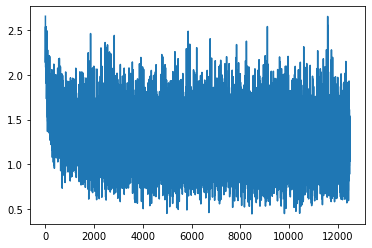

CPU times: user 16min 28s, sys: 3min 4s, total: 19min 32s
Wall time: 19min 39s


In [16]:
%%time
resnet = resnet.to(gpu)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(resnet.parameters(), lr=0.01)
model = resnet_network()
best_model, train, test = model.fit(resnet,4,trainloader,testloader,loss_fn,opt,batch_size)

In [17]:
resnet.load_state_dict(best_model)
print(model.evaluation(resnet, train), model.evaluation(resnet, test))

57.208 56.64
